## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import vit_b_16
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
import numpy as np
import os
import re

In [ ]:

if not os.path.exists("saved_models"):
    os.makedirs("saved_models")

## Function Definition

In [ ]:
from sklearn.metrics import roc_auc_score

def custom_metric(y_true, y_pred, min_tpr=0.8):
    """
    Calculate the partial AUC (pAUC) based on a minimum TPR threshold.

    Args:
    y_true (array): True binary labels.
    y_pred (array): Predicted probabilities.
    min_tpr (float): Minimum TPR threshold (default: 0.8).

    Returns:
    float: Scaled pAUC value.
    """
    max_fpr = 1 - min_tpr  
    v_gt = abs(y_true - 1)  
    v_pred = np.array([1.0 - x for x in y_pred])  

    
    pauc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    pauc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (pauc_scaled - 0.5)

    return pauc

## Model Definition

In [ ]:
def load_pretrained_vit(num_classes):
    """
    Load the Vision Transformer (ViT) model, downloading pretrained weights if necessary,
    and freeze all layers except the last transformer encoder and classification layer.
    """
    model_path = "saved_models/vit_b_16.pth"
    
    if os.path.exists(model_path):
        print(f"Loading pretrained ViT model from {model_path}.")
        model = vit_b_16()
        model.load_state_dict(torch.load(model_path))
    else:
        print(f"Downloading and saving ViT pretrained weights to {model_path}.")
        model = vit_b_16(pretrained=True)
        torch.save(model.state_dict(), model_path)

    
    for param in model.parameters():
        param.requires_grad = False

    
    for param in model.encoder.layers[-1].parameters():
        param.requires_grad = True

    
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, num_classes)
    for param in model.heads.head.parameters():
        param.requires_grad = True

    return model


## Hyperparams

In [ ]:

batch_size = 32
learning_rate = 0.000005
num_epochs = 50
num_classes = 2
dropout_rate = 0.4


## Dataset Processing

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

dataset = datasets.ImageFolder(root='../../data/balanced_data', transform=transform)
num_classes = len(dataset.classes)


train_indices, temp_indices, train_labels, temp_labels = train_test_split(
    np.arange(len(dataset)),
    [label for _, label in dataset.samples],
    test_size=0.2,
    stratify=[label for _, label in dataset.samples],
    random_state=42
)

val_indices, test_indices, _, _ = train_test_split(
    temp_indices,
    temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)


train_dataset = Subset(dataset, train_indices)
train_augmented_dataset = datasets.ImageFolder(root='../../data/balanced_data', transform=augment_transform)
train_augmented_indices = np.random.choice(train_indices, size=len(train_indices), replace=False)
train_augmented_dataset = Subset(train_augmented_dataset, train_augmented_indices)
train_combined_dataset = ConcatDataset([train_dataset, train_augmented_dataset])

val_dataset = Subset(dataset, val_indices)
val_augmented_dataset = datasets.ImageFolder(root='../../data/balanced_data', transform=augment_transform)
val_augmented_indices = np.random.choice(val_indices, size=len(val_indices), replace=False)
val_augmented_dataset = Subset(val_augmented_dataset, val_augmented_indices)
val_combined_dataset = ConcatDataset([val_dataset, val_augmented_dataset])

test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_combined_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_combined_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Init Model

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_pretrained_vit(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Loading pretrained ViT model from saved_models/vit_b_16.pth.


C:\Users\jonec\AppData\Local\Temp\ipykernel_59560\979053885.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


## Eval

In [ ]:

best_model_path = "saved_models/best_model.pth"
if not os.path.exists(best_model_path):
    raise FileNotFoundError(f"No model file found at {best_model_path}.")

print(f"Loading the best model: {best_model_path}")
model.load_state_dict(torch.load(best_model_path))
model.eval()


running_test_loss = 0.0
correct_test = 0
total_test = 0
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()

        probs = torch.softmax(outputs, dim=1)[:, 1]  

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

        correct_test += torch.sum(torch.argmax(outputs, dim=1) == labels).item()
        total_test += labels.size(0)


avg_test_loss = running_test_loss / len(test_loader)
test_accuracy = correct_test / total_test
print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


pAUC = custom_metric(np.array(all_labels), np.array(all_probs), min_tpr=0.8)
print(f"Partial AUC (pAUC) above TPR=0.8 (normalized to [0, 0.2]): {pAUC:.4f}")


Loading the best model: saved_models/best_model.pth


C:\Users\jonec\AppData\Local\Temp\ipykernel_59560\3418479573.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))
c:\Users\

Test Loss: 0.4553, Test Accuracy: 0.8354
Partial AUC (pAUC) above TPR=0.8 (normalized to [0, 0.2]): 0.1053


## Plotting

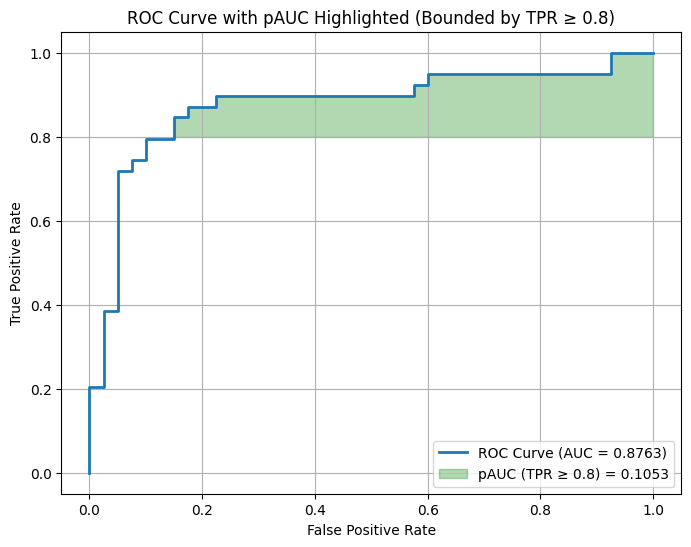

ROC Curve plot saved to saved_models\roc_curve_with_pauc.png


In [ ]:

fpr, tpr, _ = roc_curve(all_labels, all_probs)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(all_labels, all_probs):.4f})", linewidth=2)


tpr_threshold = 0.8


fpr_interp = np.interp(tpr_threshold, tpr, fpr)


fpr_bounded = np.concatenate(([fpr_interp], fpr[tpr >= tpr_threshold]))
tpr_bounded = np.concatenate(([tpr_threshold], tpr[tpr >= tpr_threshold]))


plt.fill_between(
    fpr_bounded, 
    tpr_bounded, 
    tpr_threshold, 
    color="green", 
    alpha=0.3, 
    label=f"pAUC (TPR ≥ {tpr_threshold}) = {pAUC:.4f}"
)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with pAUC Highlighted (Bounded by TPR ≥ 0.8)")
plt.legend(loc="lower right")
plt.grid(True)


roc_plot_path = os.path.join("saved_models", "roc_curve_with_pauc.png")
plt.savefig(roc_plot_path, bbox_inches="tight")
plt.show()
print(f"ROC Curve plot saved to {roc_plot_path}")